In [1]:
import numpy as np
from numpy.linalg import inv as inv

import matplotlib.pyplot as plt
import time

def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

def mySVD(mat):
    ## faster SVD
    [m, n] = mat.shape
    if 2 * m < n:
        u, s, v = np.linalg.svd(mat @ mat.T, full_matrices = 0)
        s = np.sqrt(s)
        tol = n * np.finfo(float).eps
        idx = np.sum(s > tol)
        return u[:,:idx] , s[:idx],  np.diag(1/s[:idx]) @ u[:,:idx].T @ mat
    elif m > 2 * n:
        v,s,u = my_SVD(mat.T, τ)
        return u, s ,v
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    return u,s,v
    
def svt_NC(mat, L_l, k, α, ε, ρ):
    τ = α[k]/ρ
    _,σ,_ = mySVD(ten2mat(L_l,k))    
    ωk =  1/σ +ε[k]
    u,s,v =  mySVD(mat)                
    ss = s- τ * ωk
    idx = np.sum(ss>0 )
    vec = ss[:idx].copy()
    return u[:, :idx] @ np.diag(vec) @ v[:idx, :]
    
def compute_rmse(var, var_hat):
    return np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def plot(rmse,mape,dataset,missing_rate,mode,duration):

    fig = plt.figure(figsize=(6, 5))
    plt.rc('font',family='Times New Roman')
    ax1= fig.add_subplot(111)
    ax1.plot(mape,label='MAPE')
    
    ax2=ax1.twinx()
    ax2.plot(rmse,color='orange',label='RMSE')
    plt.title('%s - %s - %.1f ' %(mode,dataset,missing_rate),size=15)
    ax1.text( 0.1,0.4, ' MAPE(min): %.3f  loc: %d \n RMSE(min): %.3f  loc: %d \n \n MAPE(last): %.3f \n RMSE(last): %.3f  \n Duration: %d seconds' 
             %(mape.min()*100, mape.argmin(), rmse.min(), rmse.argmin(), mape[-1]*100, rmse[-1],duration), transform=ax1.transAxes, size=15 )
    ax1.legend(loc='upper left',fontsize=14)
    ax2.legend(loc='upper right',fontsize=14)


def TC_PFNC(dense_tensor, sparse_tensor, ρ, ε, α, tol, K, pos_missing, pos_test ):
    ''' dense_tensor:  ground truth tensor
        sparse_tensor: observed tensor
        ε : a small constant
        α : weight parameters of each mode
        tol : tolerance
        K : max iteration
        '''
    ## tensor shape
    dim = np.array(sparse_tensor.shape)
    ## Initialization：
    ## observed tensor 
    M = sparse_tensor.copy()                         # shape: n1*n2*n3
    ## low-rank tensor
    L = sparse_tensor.copy()                         # shape: n1*n2*n3  
    L3 = np.zeros(np.insert(dim, 0, len(dim)))       # shape: 3*n1*n2*n3
    ## multiplier tensor
    T3 = np.zeros(np.insert(dim, 0, len(dim)))       # shape: 3*n1*n2*n3
    ## RMSE and MAPE
    RMSE = np.zeros(K)
    MAPE = np.zeros(K)
    
    it = 0
    while True:

        ## update Lk
        L_l = L.copy()
        for k in range(3):
            L3[k] = mat2ten(svt_NC(ten2mat((M - T3[k]/ρ), k), L_l, k, α, ε, ρ ), dim, k)
        
        ## update M
        M[pos_missing] = np.mean(L3 + T3/ρ, axis=0)[pos_missing]
        
        ## update T
        T3 = T3 + ρ*( L3 - np.broadcast_to(M, np.insert(dim, 0, len(dim))))
        
        ## Update L
        L = np.einsum('k, kmnt -> mnt', α, L3)
        
        ## compute the tolerance
        tole = np.sqrt(np.sum((L - L_l) ** 2)) / np.sqrt(np.sum((L_l) ** 2))
        
        ## compute the MAPE, RMSE 
        mape = compute_mape(dense_tensor[pos_test], L[pos_test])
        rmse = compute_rmse(dense_tensor[pos_test], L[pos_test])
        MAPE[it] = mape
        RMSE[it] = rmse
    
        if (tole < tol) or (it+1 >= K):
            break
    
        if (it + 1) % 1000 == 0:
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(mape))
            print('RMSE: {:.6}'.format(rmse))
            print()
            
        ## update iteration
        it +=1

    print('Total iteration: {}'.format(it+1))
    print('Tolerance: {:.6}'.format(tole))
    print('Imputation MAPE: {:.6}'.format(mape))
    print('Imputation RMSE: {:.6}'.format(rmse))
    print()

    return L,MAPE,RMSE

### Experiments on Guangzhou Data Set

#### Random missing (RM) scenario

In [2]:
import scipy.io
import time

def G_RM_(ms):
    ''' ms: missing_rate'''
    dense_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')['tensor']
    random_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_tensor.mat')['random_tensor']
    binary_tensor = np.round(random_tensor + 0.5 - ms)
    sparse_tensor = np.multiply(dense_tensor, binary_tensor)
    
    pos_missing = np.where(sparse_tensor == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    
    start = time.time()
    ρ = 1e-5
    ε = np.ones(3) * 1e-6
    α = np.ones(3) / 3
    tol = 1e-6
    K = 400 
    L,MAPE,RMSE = TC_PFNC(dense_tensor, sparse_tensor, ρ, ε, α, tol, K, pos_missing, pos_test)  
    end = time.time()
    plot(RMSE,MAPE,'G',ms,'RM',end - start)
    print('Running time: %d seconds'%(end - start))

Total iteration: 400
Tolerance: 0.0133453
Imputation MAPE: 0.0648318
Imputation RMSE: 2.75611

Running time: 123 seconds


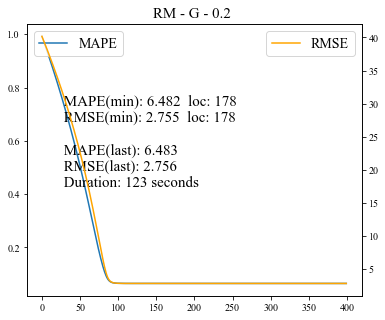

In [3]:
G_RM_(0.2)

Total iteration: 400
Tolerance: 0.0171676
Imputation MAPE: 0.0711236
Imputation RMSE: 3.02338

Running time: 135 seconds


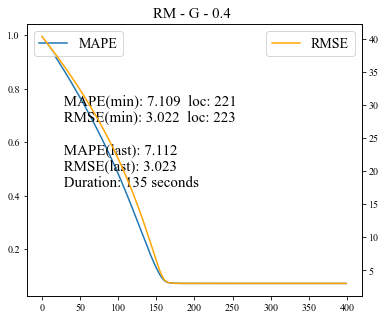

In [4]:
G_RM_(0.4)

Total iteration: 400
Tolerance: 0.0217807
Imputation MAPE: 0.0792929
Imputation RMSE: 3.36113

Running time: 143 seconds


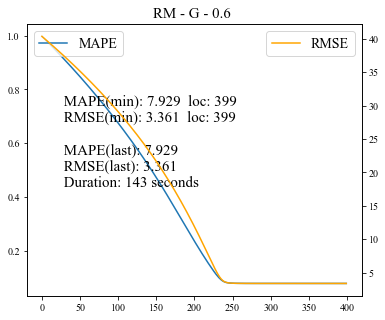

In [5]:
G_RM_(0.6)

Total iteration: 400
Tolerance: 0.024308
Imputation MAPE: 0.0890172
Imputation RMSE: 3.76024

Running time: 151 seconds


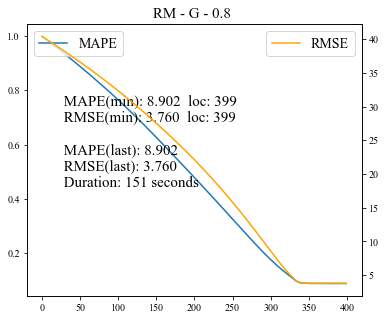

In [6]:
G_RM_(0.8)

#### Non-random missing (NM) scenario

In [7]:
import scipy.io
import time

def G_NM_(ms):
    ''' ms: missing_rate'''
    dense_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')['tensor'].transpose(0, 2, 1)
    dim1, dim2, dim3 = dense_tensor.shape
    np.random.seed(1000)
    binary_tensor = np.round(np.random.rand(dim1, dim3) + 0.5 - ms)[:, None, :]
    sparse_tensor = np.multiply(dense_tensor, binary_tensor)
    
    pos_missing = np.where(sparse_tensor == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    
    start = time.time()
    ρ = 4e-6
    ε = np.ones(3) * 1e-6
    α = np.ones(3) / 3
    tol = 1e-6
    K = 800 if(ms<=0.6) else 1200 if(ms==0.8) else 0
    L,MAPE,RMSE = TC_PFNC(dense_tensor, sparse_tensor, ρ, ε, α, tol, K, pos_missing, pos_test)  
    end = time.time()
    plot(RMSE,MAPE,'G',ms,'NM',end - start)
    print('Running time: %d seconds'%(end - start))

Total iteration: 800
Tolerance: 0.0448366
Imputation MAPE: 0.0952632
Imputation RMSE: 3.98664

Running time: 230 seconds


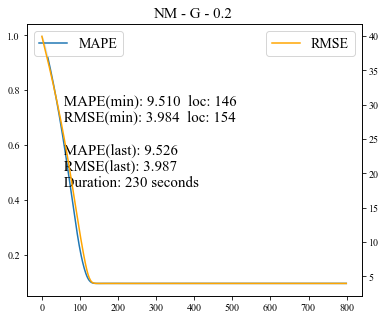

In [8]:
G_NM_(0.2)

Total iteration: 800
Tolerance: 0.0460311
Imputation MAPE: 0.096545
Imputation RMSE: 4.08011

Running time: 253 seconds


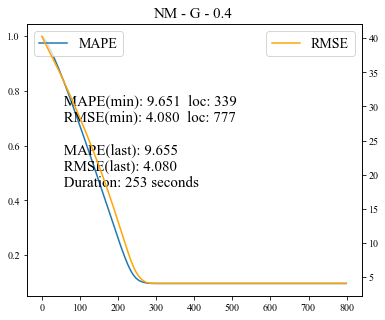

In [9]:
G_NM_(0.4)

Total iteration: 800
Tolerance: 0.0447125
Imputation MAPE: 0.0997556
Imputation RMSE: 4.21462

Running time: 275 seconds


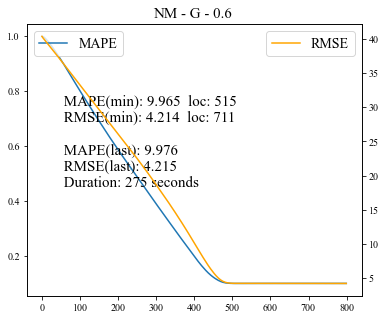

In [10]:
G_NM_(0.6)

Iter: 1000
MAPE: 0.114976
RMSE: 5.11017

Total iteration: 1200
Tolerance: 0.0373722
Imputation MAPE: 0.106551
Imputation RMSE: 4.44451

Running time: 438 seconds


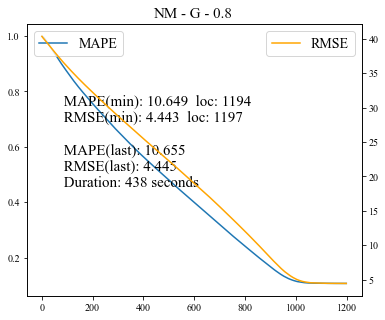

In [11]:
G_NM_(0.8)

### Experiments on PeMS Data Set

#### Random missing (RM) scenario

In [12]:
def P_RM_(ms):
    ''' ms: missing_rate'''
    dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')
    random_tensor = np.load('../datasets/PeMS-data-set/random_tensor.npy')
    dense_tensor = mat2ten(dense_mat, np.array(random_tensor.shape), 0)
    binary_tensor = np.round(random_tensor + 0.5 - ms)
    sparse_tensor = np.multiply(dense_tensor, binary_tensor)
    
    pos_missing = np.where(sparse_tensor == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))

    start = time.time()
    ρ = 1e-5
    ε = np.ones(3) * 1e-6
    α = np.ones(3) / 3
    tol = 1e-6
    K = 900 
    L,MAPE,RMSE = TC_PFNC(dense_tensor, sparse_tensor, ρ, ε, α, tol, K, pos_missing, pos_test)
    end = time.time()
    plot(RMSE,MAPE,'P',ms,'RM',end - start)
    print('Running time: %d seconds'%(end - start))

Total iteration: 900
Tolerance: 0.0153755
Imputation MAPE: 0.0233186
Imputation RMSE: 1.72515

Running time: 432 seconds


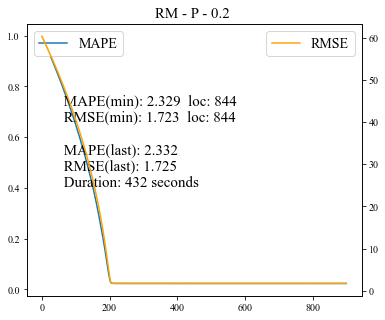

In [13]:
P_RM_(0.2)

Total iteration: 900
Tolerance: 0.014071
Imputation MAPE: 0.0269504
Imputation RMSE: 1.98966

Running time: 471 seconds


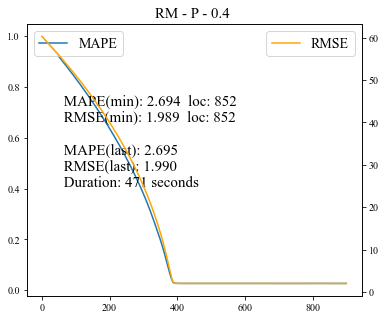

In [14]:
P_RM_(0.4)

Total iteration: 900
Tolerance: 0.0123216
Imputation MAPE: 0.0335198
Imputation RMSE: 2.46313

Running time: 525 seconds


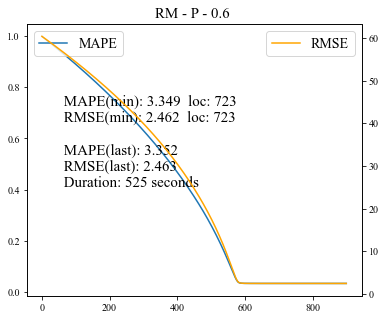

In [15]:
P_RM_(0.6)

Total iteration: 900
Tolerance: 0.00871524
Imputation MAPE: 0.0539889
Imputation RMSE: 3.78288

Running time: 576 seconds


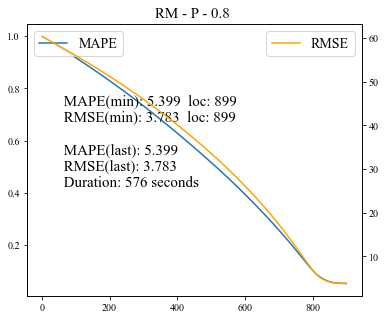

In [16]:
P_RM_(0.8)

#### Non-random missing (NM) scenario

In [17]:
def P_NM_(ms):
    ''' ms: missing_rate'''
    dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')
    dense_tensor = mat2ten(dense_mat, np.array([228,288,44]), 0)
    dim1, dim2, dim3 = dense_tensor.shape
    np.random.seed(1000)
    binary_tensor = np.round(np.random.rand(dim1, dim3) + 0.5 - ms)[:, None, :]
    sparse_tensor = np.multiply(dense_tensor, binary_tensor)
    
    pos_missing = np.where(sparse_tensor == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    
    start = time.time()
    ρ = 1e-6
    ε = np.ones(3) * 1e-6
    α = np.ones(3) / 3
    tol = 1e-6
    K = 300 if(ms==0.2) else 500 if(ms==0.4) else 800 if(ms==0.6) else 1200 if(ms==0.8) else 0
    L,MAPE,RMSE = TC_PFNC(dense_tensor, sparse_tensor, ρ, ε, α, tol, K, pos_missing, pos_test)  
    end = time.time()
    plot(RMSE,MAPE,'P',ms,'NM',end - start)
    print('Running time: %d seconds'%(end - start))

Total iteration: 300
Tolerance: 0.0554419
Imputation MAPE: 0.0679203
Imputation RMSE: 4.84251

Running time: 152 seconds


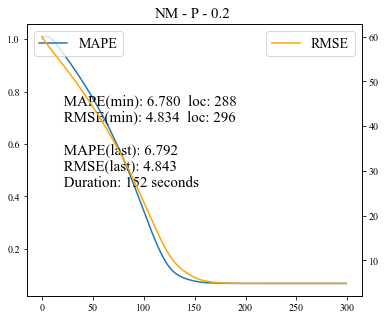

In [18]:
P_NM_(0.2)

Total iteration: 500
Tolerance: 0.0516011
Imputation MAPE: 0.0773343
Imputation RMSE: 5.31948

Running time: 277 seconds


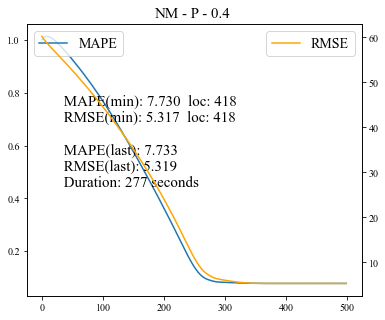

In [19]:
P_NM_(0.4)

Total iteration: 800
Tolerance: 0.0457654
Imputation MAPE: 0.0867285
Imputation RMSE: 5.80857

Running time: 459 seconds


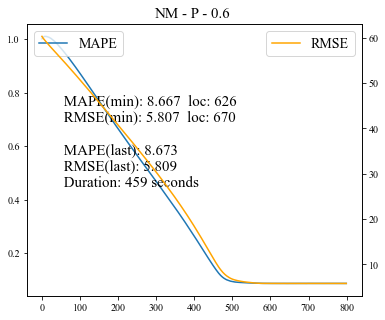

In [20]:
P_NM_(0.6)

Iter: 1000
MAPE: 0.160427
RMSE: 12.1534

Total iteration: 1200
Tolerance: 0.0364664
Imputation MAPE: 0.104823
Imputation RMSE: 7.95285

Running time: 744 seconds


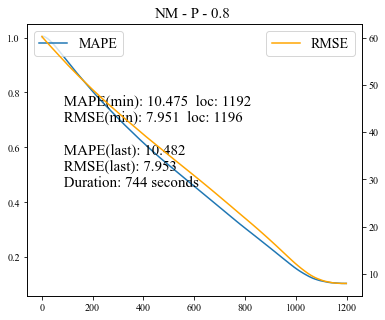

In [21]:
P_NM_(0.8)

### Experiments on Seattle Data Set

#### Random missing (RM) scenario

In [22]:
import scipy.io
import time
import pandas as pd

def S_RM_(ms):
    dense_mat = pd.read_csv('../datasets/Seattle-data-set/mat.csv', index_col = 0).values
    random_mat = pd.read_csv('../datasets/Seattle-data-set/RM_mat.csv', index_col = 0).values
    dense_tensor = dense_mat.reshape([dense_mat.shape[0], 28, 288])
    random_tensor = random_mat.reshape([random_mat.shape[0], 28, 288])
    binary_tensor = np.round(random_tensor + 0.5 - ms)
    sparse_tensor = np.multiply(dense_tensor, binary_tensor)
    
    pos_missing = np.where(sparse_tensor == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    
    start = time.time()
    ρ = 1e-5
    ε = np.ones(3) * 1e-6
    α = np.ones(3) / 3
    tol = 1e-6
    K = 800 
    L,MAPE,RMSE = TC_PFNC(dense_tensor, sparse_tensor, ρ, ε, α, tol, K, pos_missing, pos_test)
    end = time.time()
    plot(RMSE,MAPE,'S',ms,'RM',end - start)
    print('Running time: %d seconds'%(end - start))

Total iteration: 800
Tolerance: 0.0132103
Imputation MAPE: 0.0446549
Imputation RMSE: 2.95569

Running time: 377 seconds


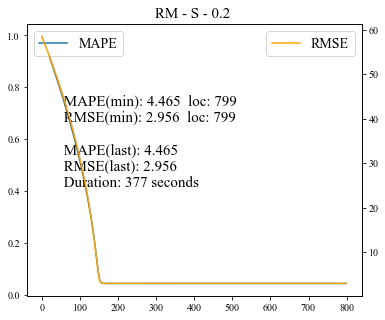

In [23]:
S_RM_(0.2)

Total iteration: 800
Tolerance: 0.0160368
Imputation MAPE: 0.0484907
Imputation RMSE: 3.15212

Running time: 412 seconds


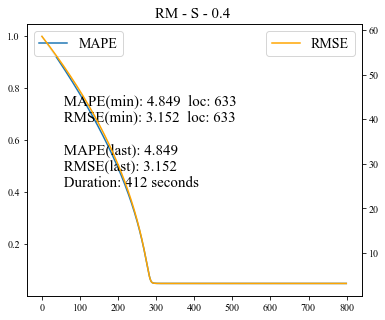

In [24]:
S_RM_(0.4)

Total iteration: 800
Tolerance: 0.0173836
Imputation MAPE: 0.0535066
Imputation RMSE: 3.41244

Running time: 444 seconds


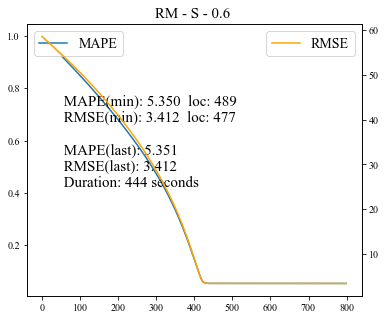

In [25]:
S_RM_(0.6)

Total iteration: 800
Tolerance: 0.0146375
Imputation MAPE: 0.0658179
Imputation RMSE: 4.04887

Running time: 477 seconds


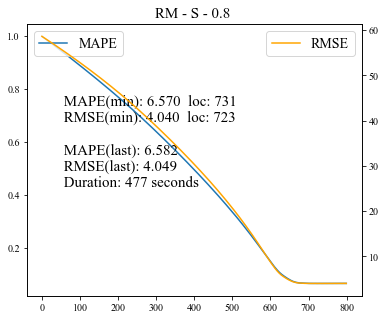

In [26]:
S_RM_(0.8)

#### Non-random missing (NM) scenario

In [2]:
import scipy.io
import time
import pandas as pd

def S_NM_(ms):
    dense_mat = pd.read_csv('../datasets/Seattle-data-set/mat.csv', index_col = 0).values
    dense_tensor = dense_mat.reshape([dense_mat.shape[0], 28, 288]).transpose(0, 2, 1)
    dim1, dim2, dim3 = dense_tensor.shape
    np.random.seed(1000)
    binary_tensor = np.round(np.random.rand(dim1, dim3) + 0.5 - ms)[:, None, :]
    sparse_tensor = np.multiply(dense_tensor, binary_tensor)
    
    pos_missing = np.where(sparse_tensor == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    
    start = time.time()
    ρ = 5e-6
    ε = np.ones(3) * 1e-6
    α = np.ones(3) / 3
    tol = 1e-6
    K = 2000 if(ms<=0.4) else 4000 if(ms==0.6) else 8000 if(ms==0.8) else 0
    
    L,MAPE,RMSE = TC_PFNC(dense_tensor, sparse_tensor, ρ, ε, α, tol, K, pos_missing, pos_test)  
    end = time.time()
    plot(RMSE,MAPE,'S',ms,'NM',end - start)
    print('Running time: %d seconds'%(end - start))

Iter: 1000
MAPE: 0.0638349
RMSE: 4.10523

Total iteration: 2000
Tolerance: 0.0285041
Imputation MAPE: 0.061488
Imputation RMSE: 3.82388

Running time: 1024 seconds


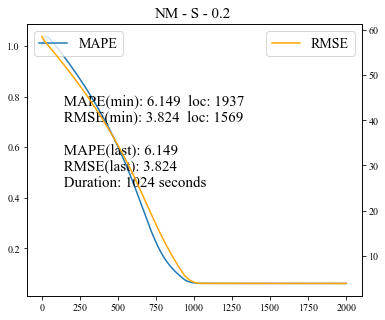

In [28]:
S_NM_(0.2)

Iter: 1000
MAPE: 0.585489
RMSE: 34.5065

Total iteration: 2000
Tolerance: 0.0302425
Imputation MAPE: 0.0680087
Imputation RMSE: 4.14865

Running time: 1073 seconds


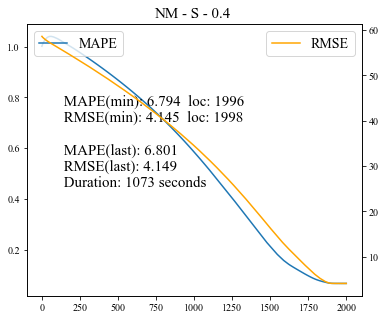

In [29]:
S_NM_(0.4)

Iter: 1000
MAPE: 0.779144
RMSE: 44.4444

Iter: 2000
MAPE: 0.429527
RMSE: 27.7695

Iter: 3000
MAPE: 0.0986042
RMSE: 6.41934

Total iteration: 4000
Tolerance: 0.0296206
Imputation MAPE: 0.0797921
Imputation RMSE: 4.75301

Running time: 2073 seconds


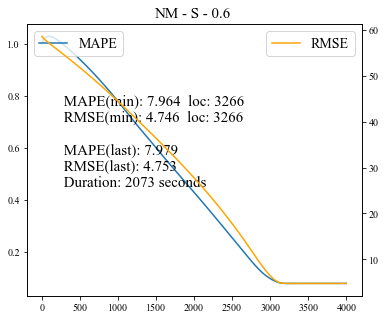

In [30]:
S_NM_(0.6)

Iter: 1000
MAPE: 0.860827
RMSE: 49.8994

Iter: 2000
MAPE: 0.684181
RMSE: 41.787

Iter: 3000
MAPE: 0.538252
RMSE: 34.4665

Iter: 4000
MAPE: 0.403422
RMSE: 27.2486

Iter: 5000
MAPE: 0.277051
RMSE: 19.951

Iter: 6000
MAPE: 0.170902
RMSE: 13.0364

Iter: 7000
MAPE: 0.121998
RMSE: 9.07409

Total iteration: 8000
Tolerance: 0.0236928
Imputation MAPE: 0.113124
Imputation RMSE: 8.4218

Running time: 4298 seconds


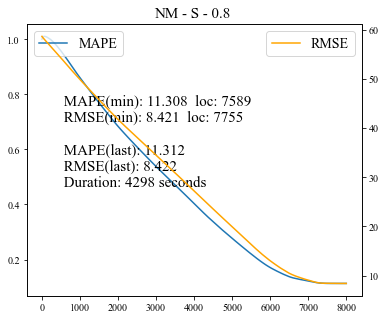

In [3]:
S_NM_(0.8)

### Experiments on Birmingham Data Set

#### Random missing (RM) scenario

In [4]:
import scipy.io
import time

def B_RM_(ms):
    ''' ms: missing_rate'''
    dense_tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/tensor.mat')['tensor']
    random_tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/random_tensor.mat')['random_tensor']
    binary_tensor = np.round(random_tensor + 0.5 - ms)
    sparse_tensor = np.multiply(dense_tensor, binary_tensor)
    
    pos_missing = np.where(sparse_tensor == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    
    start = time.time()
    ρ = 1e-6
    ε = np.ones(3) * 1e-6
    α = np.ones(3) / 3
    tol = 1e-6
    K = 1000 if(ms<=0.4) else 2000 if(ms==0.6) else 3500 if(ms==0.8) else 0
    L,MAPE,RMSE = TC_PFNC(dense_tensor, sparse_tensor, ρ, ε, α, tol, K, pos_missing, pos_test)
    end = time.time()
    plot(RMSE,MAPE,'B',ms,'RM',end - start)
    print('Running time: %d seconds'%(end - start))
    

Total iteration: 1000
Tolerance: 0.0131637
Imputation MAPE: 0.0421615
Imputation RMSE: 13.0623

Running time: 5 seconds


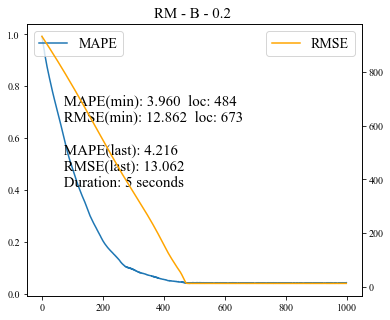

In [5]:
B_RM_(0.2)

Total iteration: 1000
Tolerance: 0.011122
Imputation MAPE: 0.0480201
Imputation RMSE: 16.5093

Running time: 5 seconds


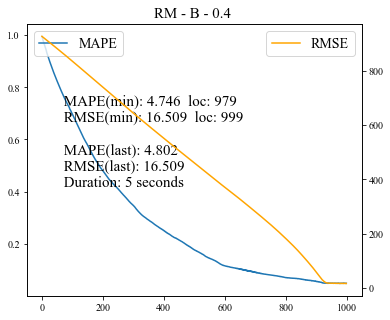

In [6]:
B_RM_(0.4)

Iter: 1000
MAPE: 0.176829
RMSE: 377.791

Total iteration: 2000
Tolerance: 0.00908824
Imputation MAPE: 0.0624488
Imputation RMSE: 22.4902

Running time: 8 seconds


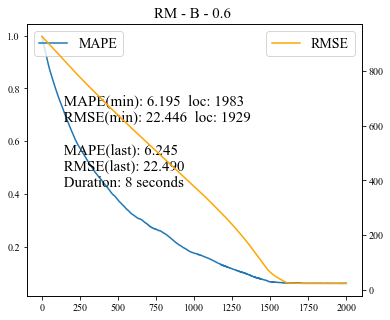

In [7]:
B_RM_(0.6)

Iter: 1000
MAPE: 0.365145
RMSE: 579.949

Iter: 2000
MAPE: 0.207647
RMSE: 303.605

Iter: 3000
MAPE: 0.0936644
RMSE: 48.7886

Total iteration: 3500
Tolerance: 0.00665986
Imputation MAPE: 0.0930319
Imputation RMSE: 36.6425

Running time: 20 seconds


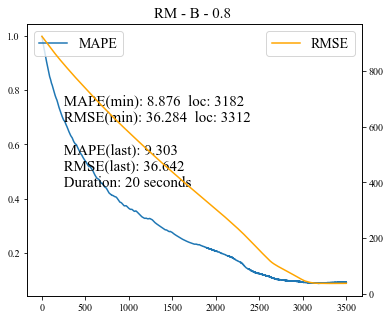

In [8]:
B_RM_(0.8)

#### Non-random missing (NM) scenario

In [9]:
import scipy.io
import time
def B_NM_(ms):
    dense_tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/tensor.mat')['tensor'].transpose(0, 2, 1)
    dim1, dim2, dim3 = dense_tensor.shape
    np.random.seed(1000)
    binary_tensor = np.round(np.random.rand(dim1, dim3) + 0.5 - ms)[:, None, :]
    sparse_tensor = np.multiply(dense_tensor, binary_tensor)
    
    pos_missing = np.where(sparse_tensor == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    
    start = time.time()
    ρ = 1e-7
    ε = np.ones(3) * 1e-6
    α = np.ones(3) / 3
    tol = 1e-6
    K = 1000 if(ms==0.2) else 1000 if(ms==0.4) else 4000 if(ms==0.6) else 4000 if(ms==0.8) else 0
    L,MAPE,RMSE = TC_PFNC(dense_tensor, sparse_tensor, ρ, ε, α, tol, K, pos_missing, pos_test)  
    end = time.time()
    plot(RMSE,MAPE,'B',ms,'NM',end - start)
    print('Running time: %d seconds'%(end - start))

Total iteration: 1000
Tolerance: 0.0344939
Imputation MAPE: 0.0756746
Imputation RMSE: 47.8975

Running time: 4 seconds


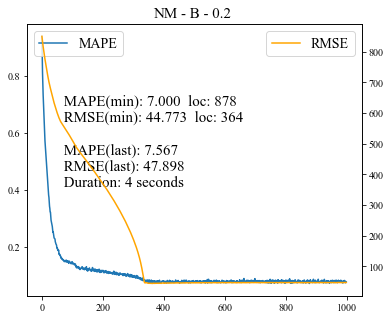

In [10]:
B_NM_(0.2)

Total iteration: 1000
Tolerance: 0.0300013
Imputation MAPE: 0.0907137
Imputation RMSE: 51.2098

Running time: 4 seconds


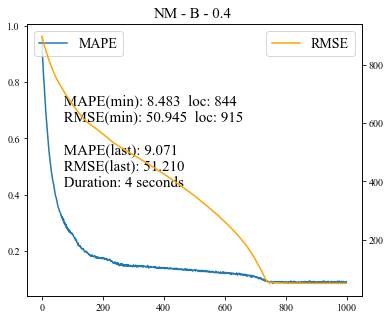

In [11]:
B_NM_(0.4)

Iter: 1000
MAPE: 0.216146
RMSE: 299.868

Iter: 2000
MAPE: 0.143777
RMSE: 102.811

Iter: 3000
MAPE: 0.147082
RMSE: 104.884

Total iteration: 4000
Tolerance: 0.0249755
Imputation MAPE: 0.146981
Imputation RMSE: 105.124

Running time: 21 seconds


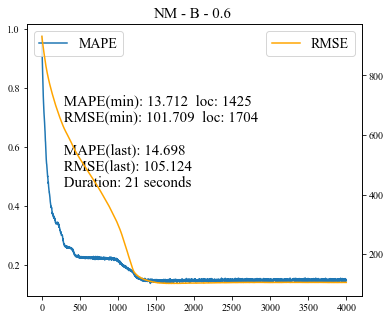

In [13]:
B_NM_(0.6)

Iter: 1000
MAPE: 0.31695
RMSE: 470.93

Iter: 2000
MAPE: 0.27317
RMSE: 216.661

Iter: 3000
MAPE: 0.252651
RMSE: 153.588

Total iteration: 4000
Tolerance: 0.0193908
Imputation MAPE: 0.24759
Imputation RMSE: 151.266

Running time: 23 seconds


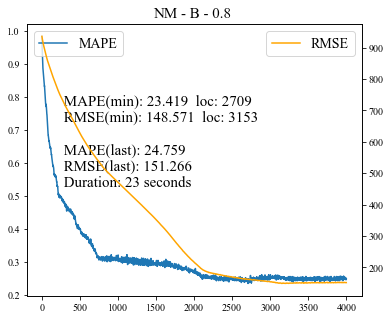

In [14]:
B_NM_(0.8)